# 赛事背景
近年来人工智能在自然语言处理领域取得了巨大的进展。其中一项引人注目的技术是生成模型，如OpenAI的GPT-3.5。这类模型通过学习大量的文本数据，具备了生成高质量文本的能力，从而引发了一系列关于文本生成真实性的讨论。 

正因为生成模型的迅猛发展，也引发了一个新的挑战，即如何区分人类编写的文本与机器生成的文本。传统上，我们借助语法错误、逻辑不连贯等特征来辨别机器生成的文本，但随着生成模型的不断改进，这些特征变得越来越难以区分。因此，为了解决这一问题，研究人员开始探索使用NLP文本分类技术来区分人类编写的文本和机器生成的文本。

# 数据说明
数据集为中文作文样本，其中从互联网上采集得到了真实作文，并且ChatGLM-6B生成了部分作文。参赛选手的任务是根据文本内容，区分作文的来源。  

本次竞赛的评价标准采用准确率 accuracy_score 指标，最高分为1。

# 任务一：报名比赛，下载比赛数据集并完成读取
<img src="img/报名.png">

In [1]:
import pandas as pd

train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")
train_data.head()

,name,label,content
0,1,0,[4509 3181 1253 2278 290 3562 2051 599 3125 ...
1,2,1,[ 263 1325 2563 4160 2196 169 3125 2563 2619 ...
2,3,0,[3635 177 3125 1251 3839 5212 2109 1171 1194 ...
3,4,1,[3037 266 246 3547 1253 2278 3125 649 697 ...
4,5,0,[ 177 3125 1547 4060 5212 4687 5164 3125 3974 ...


数据集包含三列：name、label和content。  

* name：数据的索引或编号。
* label：文本的标签，表示文本原始是否来自ChatGPT/ChatGLM。0表示人类编写的文本，1表示机器生成的文本。
* content：文本经过匿名编码后的结果，按照字符进行编码。

# 任务二：对数据集字符进行可视化，统计标签和字符分布

In [2]:
# 对输入的内容进行处理
train_data['content'] = train_data['content'].apply(lambda x: x[1:-1].strip().replace('\n', ' \n '))
test_data['content'] = test_data['content'].apply(lambda x: x[1:-1].strip().replace('\n', ' \n '))

train_data['content'] = train_data['content'].apply(lambda x: x.split())
test_data['content'] = test_data['content'].apply(lambda x: x.split())

In [3]:
# 统计字符出现的频次并输出前10个最常见的字符
from collections import Counter

c = Counter()
for content in train_data['content']:
    c.update(content)
c.most_common(10)

[('5212', 173863),
 ('3125', 116815),
 ('1759', 72557),
 ('123', 69893),
 ('0', 61434),
 ('139', 58299),
 ('205', 43617),
 ('2113', 35667),
 ('998', 28072),
 ('148', 24948)]

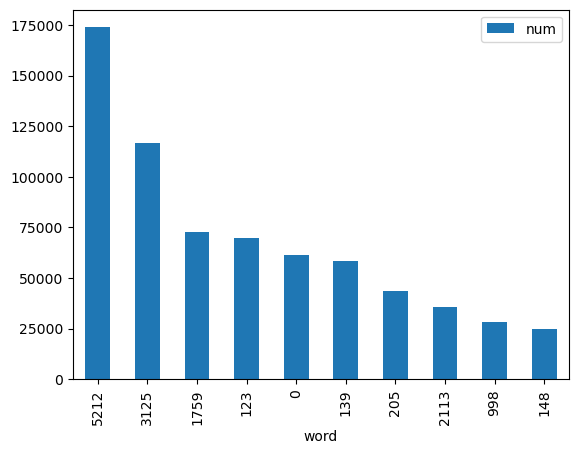

In [4]:
# 对数据集的字符进行可视化展示。
import matplotlib.pyplot as plt

counts = pd.DataFrame(c.most_common(10),columns=["word","num"])
counts = counts.sort_values(by="num",ascending=False)
counts.plot.bar(x="word",y="num")
plt.show()

# 任务三：使用TFIDF提取文本特征

## TF-IDF模型介绍

TF-IDF是一种统计方法，用以评估某一字词对于一个文件集或一个语料库的重要程度。字词的重要性随着它在文件中出现的次数成正比增加，但同时会随着它在语料库中出现的频率成反比下降。  

TF-IDF的主要思想是，如果某个词或短语在一篇文章中出现的频率TF(Term Frequency，词频)，词频高，并且在其他文章中很少出现，则认为此词或者短语具有很好的类别区分能力，适合用来分类。  

TF（Term Frequency）指的是词频，表示一个词在文档中出现的频率。IDF（inverse document frequency，逆向文件频率）是文档集合中的文档总数除以包含该词的文档数的对数。计算公式为：$IDF = \log(\frac{N}{DF + 1})$。其中，N表示文档集合中的文档总数，DF表示包含某个词的文档数。公式中的 "+1" 是为了避免分母为零的情况。取对数用于平滑计算结果，并且能够将IDF值映射到一个更合适的范围内，以便更好地与其他特征进行比较和组合。  

当一个词在更多的文档中出现时，它的IDF值趋近于0，表示这个词在文档集合中的重要性较低。相反，当一个词在较少的文档中出现时，它的IDF值较高，表示这个词在文档集合中的重要性较高。 

TF-IDF实际上是：$TF \times IDF$。得分越高表示词在文档中越重要。  

TF-IDF模型仅考虑了词频和逆文档频率，没有考虑词的顺序和语义信息。因此，在某些情况下，它可能无法捕捉到文本的完整语义信息。

## 提取文本特征

TfidfVectorizer是scikit-learn库中的一个文本特征提取工具，用于将文本数据转换为TF-IDF特征表示。下面是对TfidfVectorizer函数的功能和常用超参数的介绍：  

* ngram_range：可以指定要考虑的词组的长度范围，如(1, 1)表示只考虑单个词，(1, 2)表示同时考虑单个词和相邻的词对。
* max_features：可以限制提取的特征数量，只保留最重要的特征。
* max_df：单词的最大文档频率，超过该频率的单词将被忽略，默认为1.0，表示不忽略任何单词。
* min_df：单词的最小文档频率，低于该频率的单词将被忽略，默认为1，表示不忽略任何单词。
* stop_words：可以指定一个停用词列表，用于过滤掉常见的无意义词语，如"a"、"the"等。
* vocabulary：可以指定自定义的词汇表，用于控制所考虑的词语。
* sublinear_tf：子线性TF缩放。通过将sublinear_tf设置为True，可以使用子线性缩放来平衡长文本和短文本的特征权重，从而提高模型对不同长度文本的适应性。
* norm：特征向量的归一化方式。通过调整norm参数，可以选择不同的归一化方式，如'l2'、'l1'或'none'，以适应不同的数据分布。
* smooth_idf：控制IDF平滑的方式，设置为True表示使用平滑，避免除零错误。

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
train_tfidf_feat = tfidf.fit_transform(train_data['content'].apply(lambda x: ' '.join(x)))
test_tfidf_feat = tfidf.transform(test_data['content'].apply(lambda x: ' '.join(x)))

In [6]:
print(train_tfidf_feat.toarray())

[[0.         0.05019706 0.         ... 0.         0.07660908 0.        ]
 [0.         0.         0.         ... 0.         0.05343725 0.        ]
 [0.         0.02602664 0.         ... 0.         0.039721   0.        ]
 ...
 [0.         0.         0.         ... 0.         0.01761612 0.        ]
 [0.         0.05004152 0.         ... 0.         0.07637172 0.        ]
 [0.         0.02263174 0.         ... 0.         0.05180972 0.        ]]


In [7]:
tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=10000)
train_tfidf_feat = tfidf.fit_transform(train_data['content'].apply(lambda x: ' '.join(x)))
test_tfidf_feat = tfidf.transform(test_data['content'].apply(lambda x: ' '.join(x)))

In [8]:
print(train_tfidf_feat.toarray())

[[0.03910991 0.07374304 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.01894004 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.03226617 0.         0.         ... 0.         0.         0.        ]
 [0.0148205  0.         0.         ... 0.         0.         0.        ]]


# 任务四：使用TFIDF特征和线性模型完成训练和预测

In [9]:
from sklearn.model_selection import cross_val_predict,train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# 划分训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(train_tfidf_feat, train_data['label'], test_size=0.2, random_state=42)

# 逻辑回归模型
lr = LogisticRegression()

# 使用cross_val_predict()函数进行交叉验证
val_pred = cross_val_predict(
    lr,
    X_train,
    y_train,
    cv=5
)

# 模型在训练集上的性能
print(classification_report(y_train, val_pred, digits=3))

              precision    recall  f1-score   support

           0      0.981     1.000     0.990      9479
           1      0.999     0.895     0.944      1721

    accuracy                          0.984     11200
   macro avg      0.990     0.947     0.967     11200
weighted avg      0.984     0.984     0.983     11200



In [10]:
# 训练模型
lr.fit(X_train,y_train)
y_pred_val = lr.predict(X_val)

# 模型在验证集上的性能
print(classification_report(y_val, y_pred_val,digits=3))

              precision    recall  f1-score   support

           0      0.978     1.000     0.989      2357
           1      1.000     0.883     0.938       443

    accuracy                          0.981      2800
   macro avg      0.989     0.941     0.963      2800
weighted avg      0.982     0.981     0.981      2800



In [11]:
# 生成测试集结果
lr.fit(train_tfidf_feat, train_data['label'])
test_pred = lr.predict(test_tfidf_feat)
test_data['label'] = test_pred
test_data[['name', 'label']].to_csv('data/lr.csv', index=None)

<img src="img/lr.png">

# 任务五：使用TFIDF特征和XGBoost完成训练和预测

In [12]:
from xgboost import XGBClassifier

tfidf = TfidfVectorizer(ngram_range=(1,3), max_features=10000)
tfidf.fit(train_data['content'].apply(lambda x: ' '.join(x)))
train_tfidf_feat = tfidf.transform(train_data['content'].apply(lambda x: ' '.join(x)))
test_tfidf_feat = tfidf.transform(test_data['content'].apply(lambda x: ' '.join(x)))

# 划分训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(train_tfidf_feat, train_data['label'], test_size=0.2, random_state=42)

# 创建模型
xgb = XGBClassifier(n_estimators=50)

# 交叉验证
val_pred = cross_val_predict(
    xgb,
    X_train,
    y_train,
    cv = 5
)

# 模型在训练集上的性能
print(classification_report(y_train, val_pred, digits=3))

              precision    recall  f1-score   support

           0      0.990     0.997     0.993      9479
           1      0.981     0.944     0.962      1721

    accuracy                          0.989     11200
   macro avg      0.986     0.970     0.978     11200
weighted avg      0.989     0.989     0.988     11200



In [13]:
# 训练模型
xgb.fit(X_train,y_train)
y_pred_val = lr.predict(X_val)

# 模型在验证集上的性能
print(classification_report(y_val, y_pred_val,digits=3))

              precision    recall  f1-score   support

           0      0.841     0.995     0.912      2357
           1      0.077     0.002     0.004       443

    accuracy                          0.838      2800
   macro avg      0.459     0.499     0.458      2800
weighted avg      0.720     0.838     0.768      2800



In [14]:
# 生成测试集结果
xgb.fit(train_tfidf_feat, train_data['label'])
test_pred = xgb.predict(test_tfidf_feat)
test_data['label'] = test_pred
test_data[['name', 'label']].to_csv('data/xgb.csv', index=None)

<img src="img/xgb.png">

# 任务六：学会训练Word2Vec词向量

## Word2Vec词向量模型介绍

Word2Vec是一种用于将文本中的单词表示为向量的机器学习模型。它包含两个模型，连续词袋（Continuous Bag of Words，简称CBOW）和跳字模型（Skip-gram）。这两种方法都是基于神经网络的训练模型。CBOW模型可以根据上下文单词来预测当前单词，跳字模型可以根据当前单词来预测上下文单词。  

word2vec将字词转换成向量形式，可以把对文本内容的处理简化为向量空间中的向量运算，计算出向量空间上的相似度，来表示文本语义上的相似度。它计算的是余弦值，距离范围为0–1之间，值越大代表两个词越相似。

## 使用Word2Vec类

**Word2Vec()**
* sentences: 输入的训练数据，可以是一个可迭代对象，每个元素是一个句子的单词列表。也可以通过corpus_file参数指定从文件中读取训练数据。
* vector_size: 生成的词向量的维度，默认为100。
* alpha: 学习率（初始学习率），用于控制训练过程中的学习速度，默认为0.025。
* window: 上下文窗口大小，表示当前单词与目标单词之间的最大距离，默认为5。
* min_count: 单词的最低频次阈值，低于该频次的单词将被忽略，默认为5。
* sg: 选择训练算法，0表示CBOW，1表示Skip-gram，默认为0。
* hs: 选择层次softmax训练算法，0表示负采样，1表示层次softmax，默认为0。
* negative: 如果使用负采样，指定生成负样本的数量，默认为5。
* workers：一个用于训练并行化的参数，可以加快训练速度，默认为3.
* epochs: 训练迭代次数，默认为5。

In [49]:
from gensim.models import Word2Vec

# 创建Word2Vec模型
model = Word2Vec(sentences=list(train_data['content']), vector_size=100, window=5, min_count=1, workers=4)
print(model)

Word2Vec<vocab=4914, vector_size=100, alpha=0.025>


In [50]:
# 获取单词的向量表示
model.wv['0']

array([-0.43731368, -0.01557103, -1.1169655 ,  0.38070336, -0.866342  ,
        1.1366763 ,  1.6273082 , -0.30970496,  0.15261187, -0.28252137,
       -1.899728  ,  0.74838614, -0.23713487, -0.45594892, -0.5663476 ,
        0.21906477,  0.39660767,  1.7780344 ,  0.6653069 ,  0.04034795,
        0.29974264, -2.662975  ,  0.8533107 ,  1.7924706 , -0.7434167 ,
       -1.4550394 ,  0.1037167 , -1.2934539 , -1.5472313 ,  0.01657655,
        1.1610568 , -1.7037338 ,  0.3350013 , -0.9269314 ,  1.9165641 ,
       -1.5024201 ,  0.10790921,  0.2993678 , -1.4763    ,  1.5369719 ,
        1.0640609 , -0.560476  , -1.1750845 ,  0.8878865 ,  0.86859906,
       -1.276011  ,  1.1003003 ,  0.4173871 , -0.6910702 , -1.1921325 ,
       -1.5250986 ,  0.02588342,  0.83173174, -0.04457463,  0.41301095,
       -1.5562114 , -2.0595477 , -0.7391433 ,  0.8313659 , -0.98364526,
        0.1720823 , -0.399128  ,  0.7176993 ,  0.6142262 , -1.6582322 ,
       -0.42309308,  0.38311931, -0.63009644, -1.0117877 ,  0.36

In [23]:
# 查找与给定单词最相似的单词
model.wv.most_similar('1', topn=10)

[('14', 0.9448967576026917),
 ('67', 0.8672031760215759),
 ('82', 0.8661262392997742),
 ('81', 0.8648353815078735),
 ('87', 0.8641952872276306),
 ('63', 0.8625372052192688),
 ('77', 0.861719012260437),
 ('75', 0.8561267256736755),
 ('70', 0.8434911370277405),
 ('80', 0.8260563015937805)]

In [24]:
# 计算两个单词之间的相似度
model.wv.similarity('0', '1')

0.30987188

In [51]:
# 词向量矩阵的维度
model.wv.vectors.shape

(4914, 100)

In [53]:
# 找出这些词中与其他词汇差异最大的词
model.wv.doesnt_match(['14','67','1','70','77','75','80','81'])

'14'

# 任务七：使用Word2Vec词向量，搭建TextCNN模型进行训练和预测

## 使用Word2Vec获得训练数据

**build_vocab()**
* sentences：输入的训练数据，可以是一个可迭代对象，每个元素是一个句子的单词列表。
* update：是否更新已有的词汇表，默认为False。如果设置为True，则会在现有的词汇表基础上更新新的词汇。
* progress_per：用于显示进度的参数，表示多少个句子显示一次进度。默认为10000。
* keep_raw_vocab：是否保留原始词汇表，默认为False。如果设置为True，则在构建新的词汇表时保留原始词汇的信息。
* trim_rule：用于修剪词汇表的规则。如果指定了修剪规则函数，则会在构建词汇表后应用该函数进行修剪。

**train()**
* sentences: 输入的训练数据，与构造函数中的sentences参数相同。
* total_examples: 训练样本的总数，用于学习率调整，默认为None，如果提供了该参数，则不需要提供epochs参数。
* epochs: 训练迭代次数，用于学习率调整，默认为None，如果提供了该参数，则不需要提供total_examples参数。
* start_alpha: 初始学习率，如果没有指定，则使用构造函数中的alpha参数。
* end_alpha: 最终学习率，如果没有指定，则使用构造函数中的min_alpha参数。

In [72]:
sentences=list(train_data['content'])
# 创建Word2Vec模型
model = Word2Vec(vector_size=100, window=8, min_count=1, workers=4, epochs=20)
# 构建词汇表
model.build_vocab(sentences)
# 训练模型
model.train(sentences, total_examples=model.corpus_count,epochs=model.epochs,end_alpha=0.01)
# 得到训练数据
train_data_wv = model.wv

In [73]:
train_data_wv.vectors

array([[-0.80623174,  0.12166563, -0.99643224, ..., -0.2187935 ,
         0.669113  , -0.19976653],
       [-0.7008419 ,  0.6971608 ,  0.6098954 , ...,  0.2660851 ,
        -0.22692603, -0.41258377],
       [ 0.96653616, -0.95108795, -1.193532  , ..., -0.12667349,
         0.47273108, -0.31615722],
       ...,
       [-0.09011073, -0.1225181 ,  0.00354682, ..., -0.01854029,
        -0.03406965, -0.29819834],
       [-0.05112632,  0.04503568,  0.04370062, ...,  0.03290649,
        -0.01098526, -0.30140993],
       [ 0.01712559,  0.04288544, -0.16115916, ..., -0.04906145,
         0.01299014, -0.15191647]], dtype=float32)

## TextCNN模型介绍

TextCNN（Text Convolutional Neural Network）是一种用于文本分类的卷积神经网络模型。它的核心思想是通过卷积操作和池化操作来捕捉文本中的局部特征，从而对文本进行分类。TextCNN模型的基本结构和运行过程：
* 输入层：将文本表示为一个矩阵，每一行表示一个词或字符的词向量。
* 卷积层：TextCNN模型通常使用多个不同大小的卷积核对输入矩阵进行卷积操作。每个卷积核的目的是捕捉不同大小的局部特征。例如，对于英文文本，一个卷积核可能关注一对相邻的词语，而另一个卷积核可能关注更大范围的词语。通过卷积操作，可以得到一系列特征图（feature maps）。
* 池化层：对于每个特征图，使用最大池化（Max pooling）操作或平均池化（Average pooling）操作来降低维度。池化操作能够提取特征图中最显著的特征，并保留最重要的信息。
* 全连接层：将池化层的输出连接到一个或多个全连接层，用于学习文本的高级表示和进行分类任务。通常还会使用激活函数（如ReLU）来引入非线性。
* 输出层：最后一层是一个softmax层，将全连接层的输出映射到不同类别的概率分布。模型通过训练数据进行优化，使得在给定文本输入时，能够预测正确的分类标签。

In [76]:
# 下面是让chatgpt写的
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 构建词向量矩阵
embedding_matrix = np.zeros((len(train_data_wv) + 1, train_data_wv.vector_size))
for i, word in enumerate(train_data_wv.index_to_key):
    embedding_vector = train_data_wv[word]
    embedding_matrix[i + 1] = embedding_vector
    
# 将文本转换为词索引序列
max_seq_length = max(len(sentence) for sentence in sentences)
indexed_sentences = []
for sentence in sentences:
    indexed_sentence = [train_data_wv.key_to_index[word] + 1 for word in sentence]
    indexed_sentence += [0] * (max_seq_length - len(sentence))  # 使用0填充到相同长度
    indexed_sentences.append(indexed_sentence)

# 转换为PyTorch的Tensor类型
x_train = torch.tensor(indexed_sentences, dtype=torch.long)
y_train = torch.tensor(train_data['label'], dtype=torch.float)

# 构建数据集和数据加载器
dataset = TensorDataset(x_train, y_train)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

## 构建TextCNN模型

In [77]:
# 定义TextCNN模型
class TextCNN(nn.Module):
    def __init__(self, embedding_matrix, num_filters, filter_sizes, num_classes):
        super(TextCNN, self).__init__()

        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=True)
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, (fs, embedding_matrix.shape[1])) for fs in filter_sizes
        ])
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(len(filter_sizes) * num_filters, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)
        x = [nn.functional.relu(conv(x)).squeeze(3) for conv in self.convs]
        x = [nn.functional.max_pool1d(conv, conv.size(2)).squeeze(2) for conv in x]
        x = torch.cat(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

## 将Word2Vec词向量应用到模型中

In [79]:
# 初始化模型
vocab_size = len(word_vectors) + 1
embedding_dim = 100
num_filters = 128
filter_sizes = [2, 3, 4]
num_classes = 1
text_cnn_model = TextCNN(embedding_matrix, num_filters, filter_sizes, num_classes)

# 定义损失函数和优化器
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(text_cnn_model.parameters(), lr=0.001)

# 模型训练
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
text_cnn_model.to(device)

for epoch in range(num_epochs):
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = text_cnn_model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

Epoch [1/20], Loss: 0.0
Epoch [2/20], Loss: 2.807300006679725e-05
Epoch [3/20], Loss: 1.4900939277140424e-05
Epoch [4/20], Loss: 0.0
Epoch [5/20], Loss: 0.0
Epoch [6/20], Loss: 0.0
Epoch [7/20], Loss: 0.0
Epoch [8/20], Loss: 0.0
Epoch [9/20], Loss: 0.0
Epoch [10/20], Loss: 0.0
Epoch [11/20], Loss: 0.0
Epoch [12/20], Loss: 0.0
Epoch [13/20], Loss: 0.0
Epoch [14/20], Loss: 0.0
Epoch [15/20], Loss: 0.0
Epoch [16/20], Loss: 0.0
Epoch [17/20], Loss: 0.0
Epoch [18/20], Loss: 0.0
Epoch [19/20], Loss: 0.0
Epoch [20/20], Loss: 0.0


In [83]:
# 模型预测
test_sentences=list(test_data['content'])
indexed_test_sentences = []
for text in test_sentences:
    indexed_test_sentence = [train_data_wv.key_to_index[word] + 1 for word in text if word in train_data_wv]
    indexed_test_sentence += [0] * (max_seq_length - len(indexed_test_sentence))
    indexed_test_sentences.append(indexed_test_sentence)

x_test = torch.tensor(indexed_test_sentences, dtype=torch.long).to(device)
predictions = torch.sigmoid(text_cnn_model(x_test)).squeeze().tolist()

In [88]:
test_data['label'] = [1 if pred > 0.5 else 0 for pred in predictions]
test_data[['name', 'label']].to_csv('data/textcnn.csv', index=None)

<img src="img/textcnn.png">>

# 任务八：使用Word2Vec词向量，搭建BILSTM模型进行训练和预测

## BILSTM模型介绍
BILSTM（Bidirectional Long Short-Term Memory）是一种用于序列建模的深度学习模型，它结合了双向递归神经网络（RNN）和长短期记忆（LSTM）的思想，利用LSTM单元处理输入序列的时序信息，并且通过引入双向上下文来更好地理解和建模序列。

BILSTM模型的基本结构由两个LSTM组成，一个按原始顺序处理输入序列，另一个按相反顺序处理输入序列。这种设计允许模型同时从过去和未来的上下文中学习特征。两个方向的LSTM计算结果会被连接起来，形成最终的表示。这样，BILSTM模型可以更好地捕捉到序列中的长期依赖关系和上下文信息。

BILSTM模型的输入是一个序列，例如一个句子或一个时间序列，每个元素都表示序列中的一个时间步。每个时间步的输入都被嵌入到一个向量空间中，以便于模型处理。在经过输入层后，BILSTM模型的主要组成部分是两个LSTM层，分别处理正向和反向的上下文。每个LSTM层包含多个LSTM单元，这些单元通过一个门控机制来控制信息的流动和记忆的更新。

BILSTM模型的输出可以是各种形式，根据任务的不同而定。例如，在序列标注任务中，输出可以是每个时间步的标签；在文本分类任务中，输出可以是整个序列的分类结果。

BILSTM模型在许多NLP任务中表现出色，它能够学习到上下文相关的特征，有效地处理长距离依赖关系，对于处理序列数据具有很强的表达能力。然而，BILSTM模型也存在一些限制，例如它对序列长度的处理有限制，较长的序列可能导致内存消耗过大或模型性能下降。此外，BILSTM模型对于捕捉更大范围的上下文信息有一定的限制，因为它仅考虑了局部的前后上下文。

In [89]:
# 定义BILSTM模型
class BILSTM(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, num_layers, num_classes):
        super(BILSTM, self).__init__()

        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=True)
        self.bilstm = nn.LSTM(embedding_matrix.shape[1], hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, _) = self.bilstm(x)
        h_n = torch.cat((h_n[-2, :, :], h_n[-1, :, :]), dim=1)
        x = self.fc(h_n)
        return x

In [90]:
# 初始化模型
hidden_dim = 128
num_layers = 1
num_classes = 1
bilstm_model = BILSTM(embedding_matrix, hidden_dim, num_layers, num_classes)

# 定义损失函数和优化器
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(bilstm_model.parameters(), lr=0.001)

In [91]:
# 模型训练
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bilstm_model.to(device)

for epoch in range(num_epochs):
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = bilstm_model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

Epoch [1/20], Loss: 0.009044078178703785
Epoch [2/20], Loss: 0.0004037315375171602
Epoch [3/20], Loss: 0.002809701254591346
Epoch [4/20], Loss: 0.0032373229041695595
Epoch [5/20], Loss: 0.0002015027275774628
Epoch [6/20], Loss: 1.1920927533992653e-07
Epoch [7/20], Loss: 5.793270975118503e-05
Epoch [8/20], Loss: 4.768370445162873e-07
Epoch [9/20], Loss: 2.682201738934964e-06
Epoch [10/20], Loss: 8.344643447344424e-07
Epoch [11/20], Loss: 1.7225447663804516e-05
Epoch [12/20], Loss: 7.563468534499407e-05
Epoch [13/20], Loss: 3.483414888381958
Epoch [14/20], Loss: 0.0
Epoch [15/20], Loss: 0.0
Epoch [16/20], Loss: 0.00011991029168711975
Epoch [17/20], Loss: 3.5762775496550603e-07
Epoch [18/20], Loss: 5.9604641222676946e-08
Epoch [19/20], Loss: 0.0
Epoch [20/20], Loss: 0.0


In [92]:
# 模型预测
predictions = torch.sigmoid(bilstm_model(x_test)).squeeze().tolist()
test_data['label'] = [1 if pred > 0.5 else 0 for pred in predictions]
test_data[['name', 'label']].to_csv('data/bilstm.csv', index=None)

<img src="img/bilstm.png">

# 任务九：学会Bert基础，transformer库基础使用

Transformer 

## Bert模型介绍
BERT（Bidirectional Encoder Representations from Transformers）是由Google于2018年提出的一种预训练模型，它是基于Transformer模型的一种改进和扩展。BERT是一种双向（bidirectional）的自然语言处理模型，通过在大规模无标签文本上进行预训练，学习到了丰富的语言表示。

传统的自然语言处理模型通常采用单向的语言模型，即从左到右或从右到左进行建模，而BERT则采用了双向的机制。这使得BERT能够更好地理解上下文和语境，并在各种自然语言处理任务中表现出色。

BERT的训练过程包括两个阶段：预训练和微调。在预训练阶段，BERT使用大量无标签的文本数据进行训练，通过预测输入文本中的遮蔽词（masked words）和句子关系任务来学习词汇和句子级别的表示。在微调阶段，BERT通过在特定任务上进行少量的有标签数据的训练来适应具体的任务，如文本分类、命名实体识别、句子关系判断等。

In [ ]:
from transformers import BertTokenizer, BertModel, AutoModel



# 任务十：使用Bert在比赛数据集中完成预训练

# 任务十一：使用Bert在比赛数据集上完成微调